In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import datetime as dt

In [3]:
from settings import OUT_DATA_DIR, WORK_DATA_DIR, OUT_MODEL_DIR, test_size

In [4]:
from utils.load import load_data, save_model, save_file
from utils.utils import tts_data
from src.src import ModelValidation, StatsTest
from src.models import RandomWalk

In [5]:
# Load data
model_type = "rw"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' # 'FF' # 'FF_TS_VX'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [6]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

In [7]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
     'sp_close',
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [8]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [9]:
df_train = df_ws.copy()

In [10]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

In [11]:
stest = StatsTest(print_results=True)
stest.arr_ttest_1samp(y_train, 0)

Ttest_1sampResult(statistic=1.9494142301226356, pvalue=0.05137680953381611)
TTest one sample for mean: 0
Test statistics: 1.9494142301226356
Test pvalue: 0.05137680953381611
Population mean is equal to 0: True


True

# Model eval

In [12]:
model = RandomWalk(X_train, X_test, y_test, y_train)

In [13]:
mval = ModelValidation(X_train, y_train, X_test, y_test, model, print_results=True)

Ttest_1sampResult(statistic=1.9494142301226356, pvalue=0.05137680953381611)
TTest one sample for mean: 0
Test statistics: 1.9494142301226356
Test pvalue: 0.05137680953381611
Population mean is equal to 0: True


Testing for zero mean
Time series has a zero mean: True
Random walk requires a drift: False


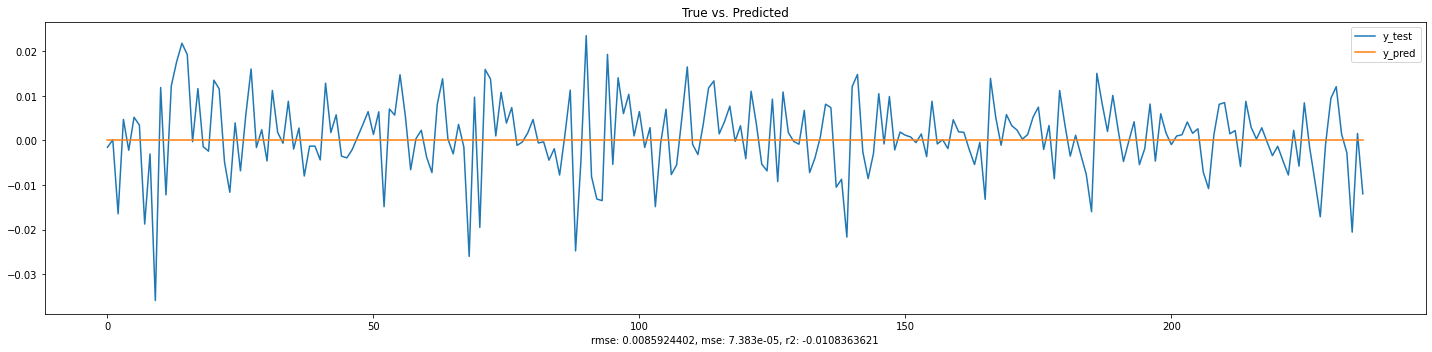

Validation Scores
root mean squared error: 0.0085924402
mean squared error: 7.383e-05
mean absolute error: 0.0063551214
R2: -0.0108363621


In [14]:
fig_truefit = mval.get_model_performance()

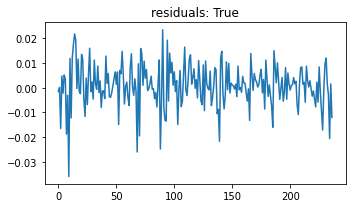

Stationarity Test Results
P-Values: 6.245905064015082e-17
Test-stats: -9.793956079680903
Time series is stationary: True
Number of lags used: 2




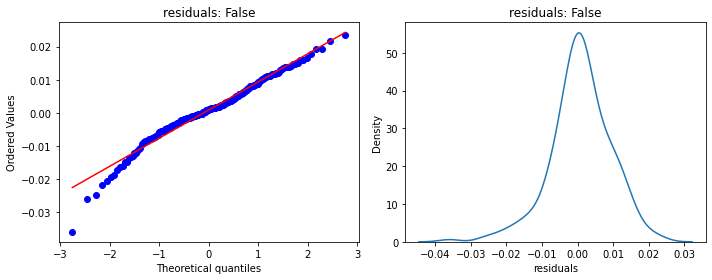

Normality Test Results
P-Values: 1.1891172839471478e-05
Test-stats: 22.679428422592075
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


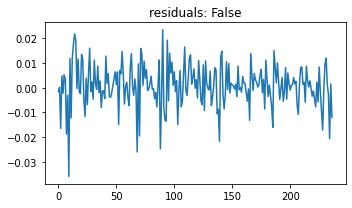

Test for Heteroskedasticity
Test p-value: 0.2888399999315443
Heteroskedasticity is present: False


Ttest_1sampResult(statistic=1.599181498946177, pvalue=0.11111816820874351)
TTest one sample for mean: 0
Test statistics: 1.599181498946177
Test pvalue: 0.11111816820874351
Population mean is equal to 0: True


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.018 < 2.5
First order autocorrlation is not present: : True



Ljung Box test
Pvalue: 0.19968461721666939
H0 the residuals are idd can be rejected: False


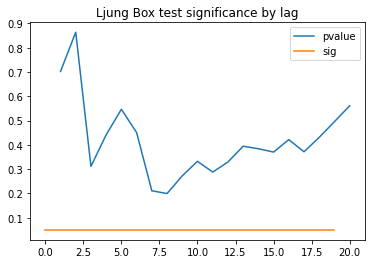

In [15]:
stat, norm, hetero, durbin_wats, zero_mean, idd_ser = mval.analyse_resids()

In [16]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(durbin_watson=durbin_wats)
data_dict["model_metrics"].update(idd_resid=idd_ser)
data_dict["model_metrics"].update(resid_zero_mean=zero_mean)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid)

data_dict['model_metrics'].update(y_pred=mval.model_wrapper.y_pred)
data_dict['model_metrics'].update(y_test=mval.model_wrapper.y_test)
data_dict['model_metrics'].update(y_prices=df_w.sp_true_vals.iloc[y_test.index[0]:])

# Save model

In [17]:
save_model(model=mval.model_wrapper, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit], 
           fig_titles=['fig_truefit',], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-05-01_rw_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
